# ToDO:
- Hook, dass die NB Outputs im pre-commit gecleared werden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from models import *
np.random.seed(42)

Creating scenarios...
Successfully created 27 scenarios and saved them to configs/scenarios.json.


In [2]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# Import Data

In [3]:
def download_bq_table_to_dataframe(project_id, dataset_id, table_id):
    # Create a BigQuery client
    client = bigquery.Client(project=project_id)

    # Construct the fully qualified table ID
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    # Query the table
    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()

    return df

In [4]:
project_id = "brain-flash-dev"
dataset_id = "dagster_common"
table_id = "CN_data_to_fetch"

In [6]:
df = download_bq_table_to_dataframe(project_id, dataset_id, table_id)

In [7]:
df.head()

,TEST_ITEM_COMMUNICATIONKEY,NA_QUOTA,TWIN_ITEM_COMMUNICATIONKEY,CALENDAR_DATE,ANSPRACHE,ANSPRACHE_MARKETING_IMPUTED,FRACTION_SOLDOUT,TWIN_COUNT,FIRST_ANSPRACHE_DATE,LAST_ANSPRACHE_DATE,FIRST_SOLDOUT_DATE,FIRST_SOLDOUT20_DATE,NA_COUNT,TEST_PERIOD,OBS_PERIOD
0,1063668113,0.0,1063668113,2020-09-09,2,2,0.0,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
1,1063668113,0.0,1063668113,2020-11-15,2,2,0.0,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
2,1063668113,0.0,1063668113,2020-11-26,1,1,0.0,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
3,842058910,0.0,842058910,2019-06-05,4,4,0.0,7,2019-05-11,2019-11-12,2019-09-24,NaT,0,185,549
4,842058910,0.0,842058910,2019-08-04,2,2,0.0,7,2019-05-11,2019-11-12,2019-09-24,NaT,0,185,549


In [7]:
df.to_csv('data/twins_100.csv', index=False)

# Local Block Bootstrap (LBB)

In [10]:
df_slice = df.query("TEST_ITEM_COMMUNICATIONKEY == 1063668113", engine='python')

In [38]:
df_slice.head()

,TEST_ITEM_COMMUNICATIONKEY,NA_QUOTA,TWIN_ITEM_COMMUNICATIONKEY,CALENDAR_DATE,ANSPRACHE,ANSPRACHE_MARKETING_IMPUTED,FRACTION_SOLDOUT,TWIN_COUNT,FIRST_ANSPRACHE_DATE,LAST_ANSPRACHE_DATE,FIRST_SOLDOUT_DATE,FIRST_SOLDOUT20_DATE,NA_COUNT,TEST_PERIOD,OBS_PERIOD
0,1063668113,0.0,1063668113,2020-09-09,2,2,0.000000,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
1,1063668113,0.0,1063668113,2020-11-15,2,2,0.000000,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
2,1063668113,0.0,1063668113,2020-11-26,1,1,0.000000,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
11,1063668113,0.0,381465921,2019-11-25,4,4,0.166667,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470
12,1063668113,0.0,655012490,2019-09-17,10,10,0.142857,10,2020-09-03,2020-12-18,2020-12-12,NaT,0,106,470


In [ ]:
#important: test data must be orderred by time


In [69]:
#lbb(mit overlapping und nicht overlapping blocks), lb, 

def lbb(test_key: int = 1063668113, B: float = 0.1, df: pd.DataFrame = df, b: int = 7, samples: int = 5000):
    df_slice = df.query("TEST_ITEM_COMMUNICATIONKEY == @test_key", engine='python')
    twins = df_slice.query("TEST_ITEM_COMMUNICATIONKEY != TWIN_ITEM_COMMUNICATIONKEY", engine='python')
    test = df_slice.query("TEST_ITEM_COMMUNICATIONKEY == TWIN_ITEM_COMMUNICATIONKEY", engine='python')

    #conditions on input...
    test_data = test.copy().sort_values(by="CALENDAR_DATE", ascending=True)["ANSPRACHE"]

    n = len(test)
    M = range(int(np.ceil(n/b)))

    bootstrap_sample = []
    #iterate number of blocks
    for m in M:
        
        #define valid neighborhood range
        J_1m = max(1, m*b-n*B)
        J_2m = min(n-b+1, m*b+n*B)

        #draw block starting index
        I_m = np.random.uniform(J_1m, J_2m)

        #draw block from sample series
        sampled_block = test_data.iloc[int(I_m-1):int(I_m+b)] #consider 0 indexing by -1
        bootstrap_sample.extend(sampled_block)

    
    #ggf shorten time series
    return test_data, bootstrap_sample

In [70]:
og, test = lbb()

In [57]:
import matplotlib.pyplot as plt

In [66]:
test[2]

8

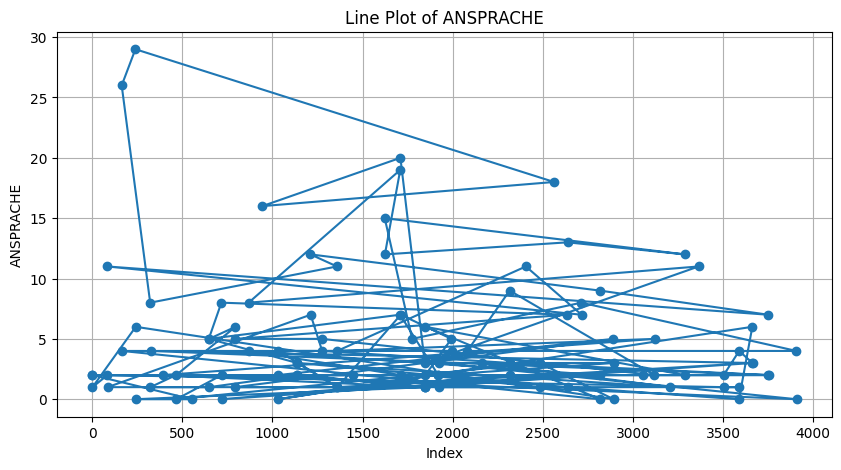

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(og, marker='o')  # Plot the list directly
plt.title('Line Plot of ANSPRACHE')
plt.xlabel('Index')
plt.ylabel('ANSPRACHE')
plt.grid()
plt.show()

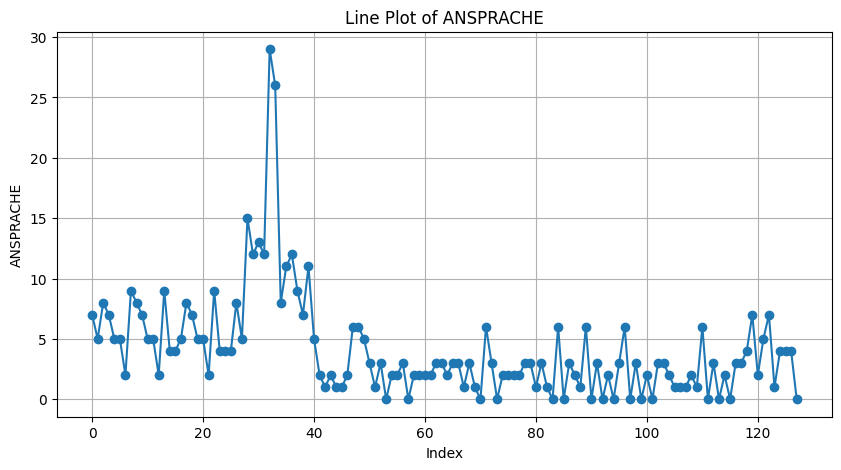

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(test, marker='o')  # Plot the list directly
plt.title('Line Plot of ANSPRACHE')
plt.xlabel('Index')
plt.ylabel('ANSPRACHE')
plt.grid()
plt.show()

## Time dependent Bootstrap sampling

In [2]:
class Sampling:
    def __init__(self, key: str, synthetic: bool, window_size: int = 7, sample_size: int = 5000):

        self.window_size = window_size
        self.sample_size = sample_size
        self.key = key
        self.paths = Paths()
        self.moments = {}

        filename = self.paths.DUMMY if synthetic else self.paths.TWINS
        with open(filename, 'r') as json_file:
            time_series = json.load(json_file)[self.key]["Twin_TS"]
            self.time_series = [np.array(ts) for ts in time_series]

        with open(self.paths.RESULTS, 'r') as json_file:
            self.dict = json.load(json_file)

        self.config = {
            "returns_level": 0,
            "returns_delay": [0],
            "marketing_effects": [1]*len(self.time_series[0])
            }
        self.horizon = len(self.time_series[0])
        if not all(len(ts) == self.horizon for ts in self.time_series):
            raise ValueError("All time series must have the same length.")
        if not isinstance(window_size, int) or window_size <= 0 or window_size % 2 == 0:
            raise ValueError("Window size must be a positive odd integer.")
        if not isinstance(sample_size, int) or sample_size <= 0:
            raise ValueError("Sample size must be a positive integer.")
        
    def bootstrap_joint_distribution(self, scenario: str = "default", mode: object ="random"):
        
        if scenario == "default":
            config = self.config
        else:
            with open(self.paths.SCENARIOS, 'r') as json_file:
                config = json.load(json_file)[scenario]

        bootstrap_samples = []
        boosted_demand = []
        
        for ts in self.time_series:
            boosted_demand.append(ts * config["marketing_effects"])

        # Generate bootstrap samples
        for _ in range(self.sample_size):
            sample = []
            for t in range(self.horizon):
                # Determine the indices for the sliding window
                start = max(0, t - self.window_size // 2)
                end = min(self.horizon, t + self.window_size // 2 + 1)
                #print(f"start: {start} to end: {end-1}")
                # Aggregate values across all time series within the sliding window
                if mode == "random":
                    window_values = np.concatenate([ts[start:end] for ts in boosted_demand])
                    sample.append(np.random.choice(window_values))
            
            bootstrap_samples.append(np.sum(sample)) #muss ich hier mean oder sum nehmen?

        bootstrap_samples = np.array(bootstrap_samples)

        # Calculate the mean and variance of the bootstrap samples
        mean = np.mean(bootstrap_samples)
        var = np.var(bootstrap_samples, ddof=1) #apply bessel correction bc we are estimating the population variance from a sample
        self.dict[self.key]["moments"][scenario] = [mean, var]
        return bootstrap_samples #warum war hier flatten?
    
    def save_results(self):
        with open(self.paths.RESULTS, 'w') as json_file:
            json.dump(self.dict, json_file, indent=4)

In [3]:
sampler = Sampling("0123456789", synthetic=False)

In [4]:
for scen in ["default", "medium_medium_deal", "medium_medium_DDM", "medium_medium_DDW"]:
    distr = sampler.bootstrap_joint_distribution(scenario = scen)
sampler.save_results()

# Normality test
- tune number of iteration until distribution is normal

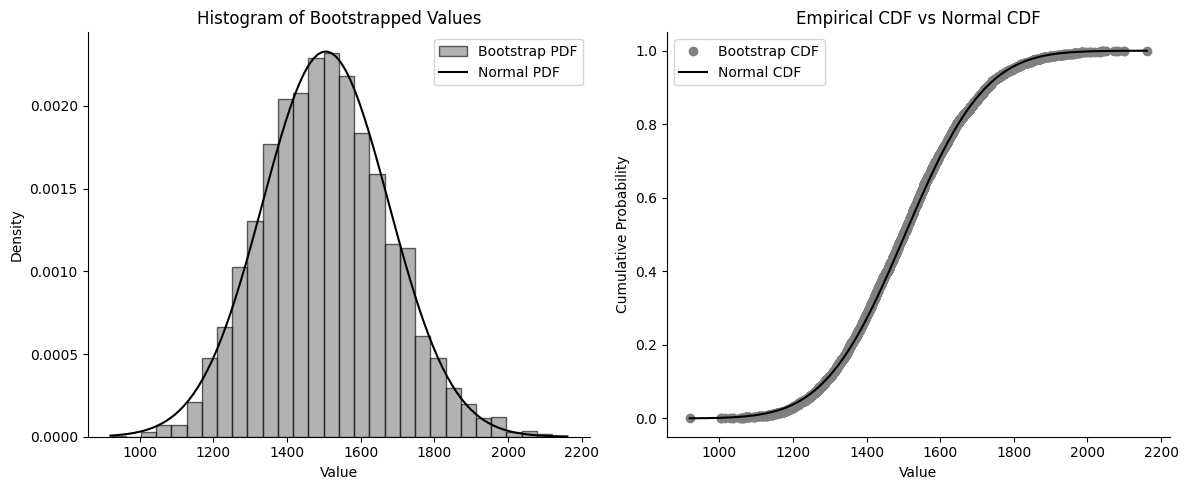

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(distr, bins=30, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(distr), max(distr), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(distr)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [6]:
#define alpha level
alpha = 0.05

In [7]:
_, p_value = stats.normaltest(distr)
print(p_value)

8.546987677552962e-09


In [8]:
_, p_value = stats.shapiro(distr)
print(p_value)

4.5215951590459825e-08
